In [183]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import math
import os
from scipy import ndimage
import random

In [184]:
SCRIPT_DIR = os.getcwd()
datasets_path = os.path.join(SCRIPT_DIR,os.pardir, "an2dl2526c2", "preprocessing_results", "train_noshreks", "train_tissue")
mask_path = os.path.join(SCRIPT_DIR,os.pardir, "an2dl2526c2", "preprocessing_results", "train_nogoo", "cleaned_masks")
DATASET_PATH = os.path.join(datasets_path)
MASK_PATH = os.path.join(mask_path)
#idx = random.randint(0,671)
idx = 182
IMG_NAME = f"img_{idx:04d}.png"
MASK_NAME = IMG_NAME.replace("img", "mask")
# Usage Example
img_path = os.path.join(DATASET_PATH, IMG_NAME)
mask_path = os.path.join(MASK_PATH, MASK_NAME)

In [190]:
def extract_smart_patches(img_path, mask_path, patch_size=224, stride=224, threshold=0.30, dilate_iterations=15):
    """
    Intelligently extracts patches. 
    UPDATED: Groups nearby tumor spots so stride actually works to reduce overlapping/redundant patches.
    """
    # Load images
    try:
        img = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        # Fallback for common extension swap if .png not found
        if img_path.endswith(".png"):
            img = Image.open(img_path.replace(".png", ".jpg")).convert("RGB")
        else:
            raise

    mask = Image.open(mask_path).convert("L")
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # Normalize mask
    if mask_arr.max() <= 1:
        mask_check = mask_arr * 255
    else:
        mask_check = mask_arr
    
    h, w, _ = img_arr.shape
    
    if isinstance(patch_size, int):
        ph, pw = patch_size, patch_size
    else:
        ph, pw = patch_size
        
    if isinstance(stride, int):
        sh, sw = stride, stride
    else:
        sh, sw = stride

    # --- Intelligent Extraction Logic ---
    
    # 1. GROUPING: Dilate the mask to merge nearby small dots into larger regions.
    # This prevents generating 1 patch per pixel-sized dot.
    # iterations=15 means dots within ~15 pixels of each other get merged.
    dilated_mask = ndimage.binary_dilation(mask_check > 128, iterations=dilate_iterations)
    
    # 2. Label the merged regions
    labeled_mask, num_features = ndimage.label(dilated_mask)
    objects = ndimage.find_objects(labeled_mask)
    
    candidate_coords = set()
    
    def get_valid_start(val, max_val, p_dim):
        return max(0, min(val, max_val - p_dim))

    print(f"Found {num_features} clustered tumor regions (after grouping).")

    for i, slice_obj in enumerate(objects):
        y_slice, x_slice = slice_obj
        
        # Region boundaries
        y_min, y_max = y_slice.start, y_slice.stop
        x_min, x_max = x_slice.start, x_slice.stop
        
        blob_h = y_max - y_min
        blob_w = x_max - x_min
        
        # --- Strategy: Center on Blob ---
        # We calculate the center of the blob and place the patch there.
        
        blob_cy = (y_min + y_max) // 2
        blob_cx = (x_min + x_max) // 2
        
        # Top-left corner for the patch to be centered on the blob center
        start_y = blob_cy - ph // 2
        start_x = blob_cx - pw // 2
        
        valid_y = get_valid_start(start_y, h, ph)
        valid_x = get_valid_start(start_x, w, pw)
        
        candidate_coords.add((valid_x, valid_y))

    # 3. Final Validation
    patches = []
    coords = []
    
    for (x, y) in candidate_coords:
        mask_patch = mask_check[y:y+ph, x:x+pw]
        img_patch = img_arr[y:y+ph, x:x+pw]
        
        # Use Tissue Threshold (non-white pixels)
        img_gray = np.mean(img_patch, axis=2)
        tissue_ratio = np.sum(img_gray < 235) / (ph * pw)
        
        # Use Mask Threshold (tumor pixels)
        mask_ratio = np.sum(mask_patch > 128) / (ph * pw)
        
        # Keep patch only if it has enough tumor AND enough tissue
        if mask_ratio >= threshold and tissue_ratio > 0.15:
            patches.append(img_patch)
            coords.append((x, y))

    return patches, coords, img_arr, mask_arr

In [193]:
# --- Execution & Visualization ---

# Run the smart extraction
valid_patches, valid_coords, full_img_arr, full_mask_arr = extract_smart_patches(
    img_path, 
    mask_path, 
    patch_size=224,   # Context window size
    stride=244,       # Overlap for large regions
    threshold=0.0001,   # Lower threshold is okay because we target specific objects
    dilate_iterations=5 # Less aggressive grouping
)
print(f"Smartly extracted {len(valid_patches)} patches focused on ROIs.")

Found 7 clustered tumor regions (after grouping).
Smartly extracted 7 patches focused on ROIs.


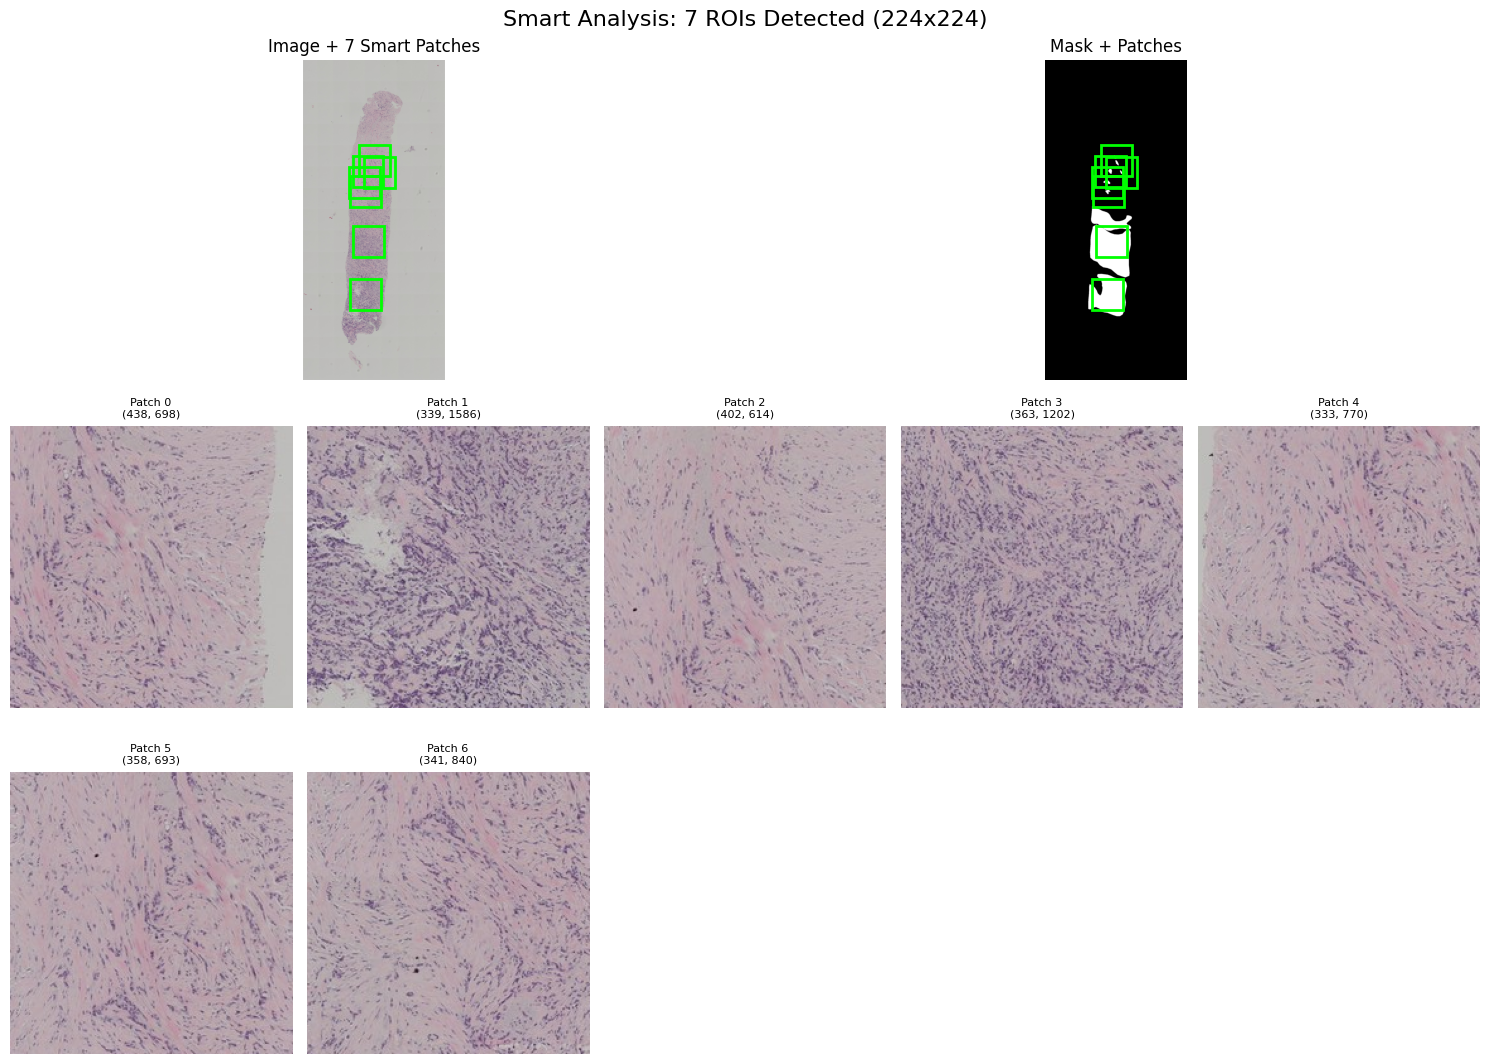

In [187]:
# Visualize
if len(valid_patches) > 0:
    n_patches = len(valid_patches)
    patch_cols = 5
    patch_rows = math.ceil(n_patches / patch_cols)
    total_rows = 1 + patch_rows 
    
    # Get actual patch dimensions for accurate plotting
    actual_h, actual_w = valid_patches[0].shape[:2]

    # Dynamic figure height
    fig = plt.figure(figsize=(15, 5 + 3 * patch_rows))
    gs = gridspec.GridSpec(total_rows, 10, figure=fig)
    fig.suptitle(f"Smart Analysis: {n_patches} ROIs Detected ({actual_h}x{actual_w})", fontsize=16)
    
    # --- 1. Image Overlay (Top Left) ---
    ax1 = fig.add_subplot(gs[0, 0:5])
    ax1.imshow(full_img_arr)
    ax1.set_title(f"Image + {n_patches} Smart Patches")
    ax1.axis('off')
    for (x, y) in valid_coords:
        # Draw rectangle matching patch size
        rect = mpatches.Rectangle((x, y), actual_w, actual_h, linewidth=2, edgecolor='lime', facecolor='none')
        ax1.add_patch(rect)

    # --- 2. Mask Overlay (Top Right) ---
    ax2 = fig.add_subplot(gs[0, 5:10])
    ax2.imshow(full_mask_arr, cmap='gray')
    ax2.set_title("Mask + Patches")
    ax2.axis('off')
    for (x, y) in valid_coords:
        rect = mpatches.Rectangle((x, y), actual_w, actual_h, linewidth=2, edgecolor='lime', facecolor='none')
        ax2.add_patch(rect)

    # --- 3. Patch Grid (Bottom Rows) ---
    for i in range(n_patches):
        r = 1 + (i // patch_cols)
        c_start = (i % patch_cols) * 2
        
        ax_patch = fig.add_subplot(gs[r, c_start:c_start+2])
        ax_patch.imshow(valid_patches[i])
        ax_patch.set_title(f"Patch {i}\n{valid_coords[i]}", fontsize=8)
        ax_patch.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No valid patches found.")